In [2]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
from keras.applications.xception import preprocess_input
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.text import Tokenizer
from keras.layers import TextVectorization
from tensorflow.keras.utils import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.layers import LSTM, Embedding, Dropout
from keras.applications.vgg16 import VGG16
from tqdm.notebook import tqdm_notebook as tqdm #to check loop progress
tqdm().pandas()

0it [00:00, ?it/s]

In [3]:
# load VGG16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [66]:
# extract features from image
features = {}
directory = os.path.join("C:\\Users\\will\\Desktop\\archive", 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature in dict
    features[image_id] = feature
    
# store features in pickle file
dump(features, open('features.pkl', 'wb'))

  0%|          | 0/8091 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
#load features from pickle file
features = load(open('features.pkl', 'rb'))

In [5]:
#Example features
img_ex = "475816542_f5c2736815.jpg"
img_ex_name = img_ex.split(".")[0]
print (features[img_ex_name])

[[0.         0.07389432 1.346098   ... 0.         0.         0.38505128]]


In [6]:
#load document and put contents in to a string 
def load_fp(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

#creates dictionary to pair images to all 5 captions in database
def img_capt(filename):
    file = load_fp(filename)
    captions = file.split("\n")
    descriptions = {}
    for capt in captions[:-1]:
        img, capt = capt.split("\t")
        if(img[:-2] not in descriptions):
            descriptions[img[:-2]] = [capt]
        else:
            descriptions[img[:-2]].append(capt)
            
    return descriptions

#data cleaning function to turn uppercase into lowercase and puncuation removal
def text_cleaning(text):
    punct = str.maketrans('','',string.punctuation)
    for img, capt in text.items():
        for i,img_capt in enumerate(capt):
            img_capt.replace("-"," ")
            desc = img_capt.split()
            desc = [wrd.lower() for wrd in desc]
            desc = [wrd.translate(punct) for wrd in desc]
            desc = [wrd for wrd in desc if(len(wrd)>1)]
            desc = [wrd for wrd in desc if(wrd.isalpha())]
            img_capt = ' '.join(desc)
            img_capt = 'startcaption ' + img_capt  + ' endcaption'
            text[img][i] = img_capt
    return text
    
#create list of all unique words in descriptions
def vocab(desc):
    vocab = set()
    for key in desc.keys():
        [vocab.update(d.split()) for d in desc[key]]
    return vocab

#save all descriptions in one file
def save_description(descriptions,filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()
    


In [7]:
with open(os.path.join('C:\\Users\\will\\Desktop\\archive', 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(mapping)

8091

In [10]:
mapping['44856031_0d82c2c7d1']

['A brown dog is sprayed with water .',
 'A dog is being squirted with water in the face outdoors .',
 'A dog stands on his hind feet and catches a stream of water .',
 'A jug is jumping up it is being squirted with a jet of water .',
 '"A tan   male dog is jumping up to get a drink of water from a spraying bottle ."']

In [11]:
dataset_text = "C:\captionProject\Flickr8k_text"
dataset_images = "C:\captionProject\Flickr8k_Dataset\Flicker8k_Dataset"

fileName = dataset_text + "/" + "Flickr8k.token.txt"
descriptions = img_capt(fileName)

print("Length of descriptions, ",len(descriptions))

cleaned_captions = text_cleaning(descriptions)
        
vocabulary = vocab(cleaned_captions)

text_cleaning(mapping)

print("Length of vocabulary list, ",len(vocabulary))

save_description(cleaned_captions, "descriptions.txt")

print("done")

Length of descriptions,  8092
Length of vocabulary list,  8765
done


In [12]:
mapping['44856031_0d82c2c7d1']

['startcaption brown dog is sprayed with water endcaption',
 'startcaption dog is being squirted with water in the face outdoors endcaption',
 'startcaption dog stands on his hind feet and catches stream of water endcaption',
 'startcaption jug is jumping up it is being squirted with jet of water endcaption',
 'startcaption tan male dog is jumping up to get drink of water from spraying bottle endcaption']

In [13]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [14]:
len(all_captions)

40455

In [21]:
all_captions[:5]

['startcaption child in pink dress is climbing up set of stairs in an entry way endcaption',
 'startcaption girl going into wooden building endcaption',
 'startcaption little girl climbing into wooden playhouse endcaption',
 'startcaption little girl climbing the stairs to her playhouse endcaption',
 'startcaption little girl in pink dress going into wooden cabin endcaption']

In [16]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [17]:
vocab_size

8766

In [18]:
#max caption length
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

In [19]:
#Splitting training and testing sets
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.9)
test = image_ids[:split]
train = image_ids[split:]

In [17]:
# create data generator to get data in batch
# rather than all at once
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # for each image 
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # for each caption of each image
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    # padding with 0s helps get better results
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [19]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')



In [18]:
# training the model
epochs = 50
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    
model.save('saved_model/model' + ".h5")

25/25 [==============================] - 46s 2s/step - loss: 0.3979


In [20]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, photo,tokenizer, max_length):
    in_text = 'startcaption'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endcaption':
            break
    return in_text



In [23]:
from nltk.translate.bleu_score import corpus_bleu
# test our model on testing data
actual, predicted = list(), list()

for key in tqdm(test):
    # actual caption
    captions = mapping[key]
    # predicted caption
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))



  0%|          | 0/7281 [00:00<?, ?it/s]

BLEU-1: 0.414681
BLEU-2: 0.177591


In [23]:
import matplotlib.pyplot as plt

def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join("C:\\Users\\will\\desktop\\archive\\images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print("REAL CAPTIONS------")
    for caption in captions:
        print(caption)
    print("PREDICTED CAPTIONS-------")
    y_pred = predict_caption(model,features[image_id], tokenizer, max_length)
    print(y_pred)
    plt.imshow(image)

In [22]:
import tensorflow as tf
model = tf.keras.models.load_model('saved_model/model.h5')

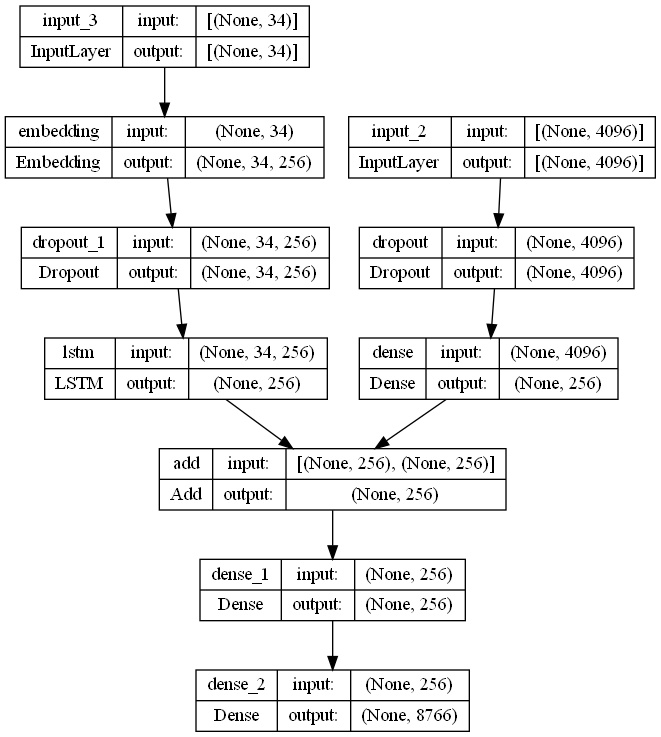

In [20]:
plot_model(model, to_file='model.png', show_shapes=True)

REAL CAPTIONS------
startcaption backpacker in the mountains using his hiking stick to point at glacier endcaption
startcaption backpacker points to the snowcapped mountains as he stands on rocky plain endcaption
startcaption hiker is pointing towards the mountains endcaption
startcaption hiker poses for picture in front of stunning mountains and clouds endcaption
startcaption man with green pack using his pole to point to snowcapped mountains endcaption
PREDICTED CAPTIONS-------
startcaption backpacker points to the snowcapped mountains as he stands on rocky plain endcaption


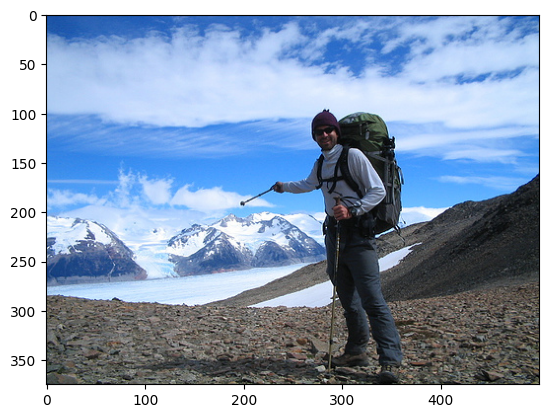

In [19]:
generate_caption("54501196_a9ac9d66f2.jpg")

REAL CAPTIONS------
startcaption lone climber on snowcapped mountain with several huge mountains in the background endcaption
startcaption man is standing looking at the path ahead while hiking in mountain range endcaption
startcaption man on top of mountain looks at the mountains surrounding him endcaption
startcaption person with backpack stands on snowy mountain endcaption
startcaption sole mountain climber stands atop snowy peak looking left endcaption
PREDICTED CAPTIONS-------
startcaption man is standing looking at the path ahead while hiking in mountains endcaption


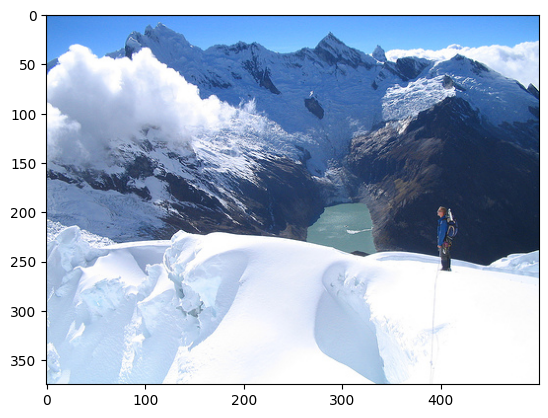

In [21]:
generate_caption("56494233_1824005879.jpg")

REAL CAPTIONS------
startcaption brown dog is running through brown field endcaption
startcaption brown dog is running through the field endcaption
startcaption brown dog with collar runs in the dead grass with his tongue hanging out to the side endcaption
startcaption brown dog with his tongue wagging as he runs through field endcaption
startcaption dog running in the grass endcaption
PREDICTED CAPTIONS-------
startcaption dog running through field endcaption


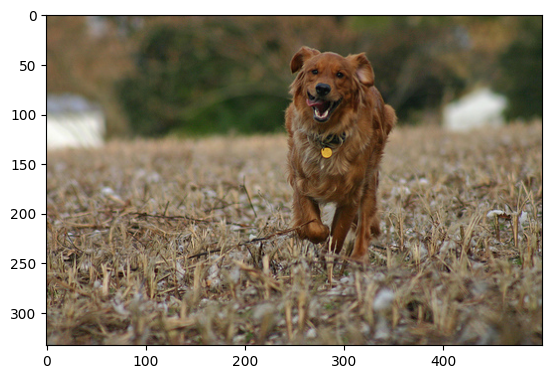

In [22]:
generate_caption("69189650_6687da7280.jpg")

REAL CAPTIONS------
startcaption black and brown dog are running toward the camera endcaption
startcaption black and yellow dog endcaption
startcaption black dog and brown dog with ball endcaption
startcaption large black dog and large yellow dog appear to be playing with soccer ball endcaption
startcaption the black dog is by soccer ball and the brown dog is running endcaption
PREDICTED CAPTIONS-------
startcaption small black and white dog is followed by larger dog in grassy yard endcaption


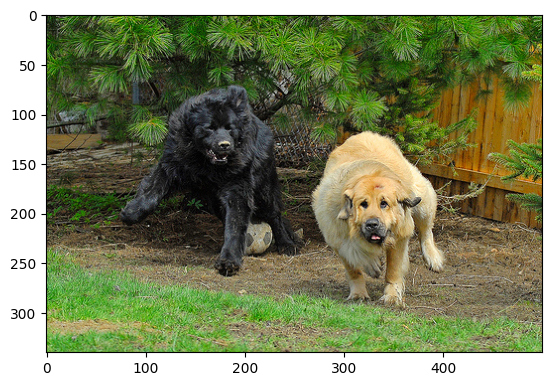

In [32]:
generate_caption("475816542_f5c2736815.jpg")

REAL CAPTIONS------
startcaption girl playing is pile of colorful balls endcaption
startcaption little girl plays in ball pit endcaption
startcaption little girl plays in pit of colorful balls endcaption
startcaption small girl is playing in ball pit endcaption
startcaption young girl with white shirt and pink shorts rolling around in some plastic multicolored balls endcaption
PREDICTED CAPTIONS-------
startcaption small boy is playing in ball pit endcaption


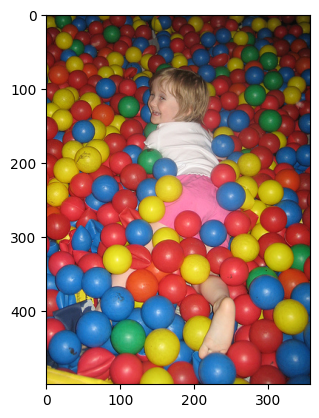

In [35]:
generate_caption("522652105_a89f1cf260.jpg")

REAL CAPTIONS------
startcaption one girl is hugging another girl in front of an american flag endcaption
startcaption two girls hugging in front of giant american flag endcaption
startcaption two girls in front of large american flag endcaption
startcaption two young girls are hugging in front of an american flag endcaption
startcaption two young girls hug in front of the american flag endcaption
PREDICTED CAPTIONS-------
startcaption two young girls hug in front of the american flag endcaption


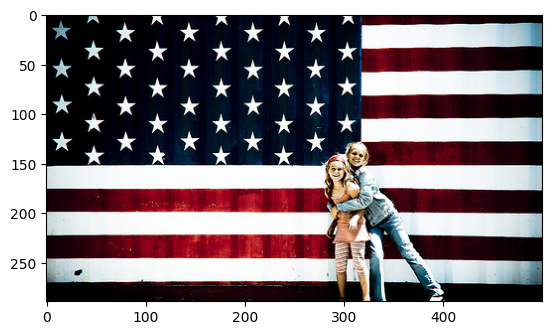

In [40]:
generate_caption("618771382_459bb492e4.jpg")

In [25]:
#Run to create captions for any picture
vgg_model = VGG16()
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [27]:
#Predict caption for any image, not just in dataset
image_path = '' #Enter the path here
# load image
image = load_img(image_path, target_size=(224, 224))
# convert to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image
image = preprocess_input(image)
# get features
feature = vgg_model.predict(image, verbose=0)
# predict caption
predict_caption(model, feature, tokenizer, max_length)

'startcaption black and brown dog is holding stick endcaption'